# Adapted from https://gist.github.com/Garfounkel/e96f2f48d1de35b21506a13cdc37a363

## Imports and definitions

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [2]:
import cudf
from cudf import Series
from cudf import DataFrame

from cuml.feature_extraction.text import TfidfVectorizer

In [3]:
import numpy as np
import pandas as pd
import warnings


pd.set_option('display.max_colwidth', 1000000)
warnings.filterwarnings('ignore')

In [4]:
def join_df(path, df_lib=cudf):
    data = df_lib.DataFrame()
    for file in os.listdir(path):
        print(f"In path : {path}{file}")
        temp = df_lib.read_csv(path+file)
        temp = temp[temp.lang=='en']
        data = df_lib.concat([data,temp])
    return data

## Taking advantage of sparsity

With the [dataset](https://www.kaggle.com/smid80/coronavirus-covid19-tweets-early-april) downloaded and extracted in a folder `/tweets`, we can load it into a dataframe using cudf:

In [5]:
df = join_df('tweets/')
tweets = Series(df['text'])
len(tweets)

In path : tweets/2020-03-29 Coronavirus Tweets.CSV
In path : tweets/2020-03-30 Coronavirus Tweets.CSV
In path : tweets/2020-03-31 Coronavirus Tweets.CSV
In path : tweets/2020-04-11 Coronavirus Tweets.CSV
In path : tweets/2020-04-12 Coronavirus Tweets.CSV
In path : tweets/2020-04-03 Coronavirus Tweets.CSV
In path : tweets/2020-04-10 Coronavirus Tweets.CSV
In path : tweets/2020-04-01 Coronavirus Tweets.CSV
In path : tweets/2020-04-07 Coronavirus Tweets.CSV
In path : tweets/2020-04-13 Coronavirus Tweets.CSV
In path : tweets/2020-04-14 Coronavirus Tweets.CSV
In path : tweets/2020-04-15 Coronavirus Tweets.CSV
In path : tweets/2020-04-09 Coronavirus Tweets.CSV
In path : tweets/2020-04-02 Coronavirus Tweets.CSV
In path : tweets/2020-04-05 Coronavirus Tweets.CSV
In path : tweets/2020-04-06 Coronavirus Tweets.CSV
In path : tweets/2020-04-08 Coronavirus Tweets.CSV
In path : tweets/2020-04-04 Coronavirus Tweets.CSV


4827372

After filtering non-english tweets, we are left with almost 5M tweets.

We can then preprocess and vectorize this data using our **TfidfVectorizer**:

In [6]:
vec = TfidfVectorizer(stop_words='english')

tfidf_matrix = vec.fit_transform(tweets)
tfidf_matrix.shape

(4827372, 5435390)

Which takes 25.9 seconds on a Tesla V100-32Gb. In comparison, scikit-learn’s TfidfVectorizer takes 2 minutes and 54.6 seconds on CPU. Notice the shape of the matrix: (4827372, 5435706). In other words 4.8M by 5.4M floats. This is huge! The only reason it can fit in GPU memory is because we store this data as a sparse matrix.

### Document search
Now that we have our TF-IDF matrix, we want to query it with some keywords to find the most relevant documents. To do this, we will rely on the fact that our TfidfVectorizer has the capability to vectorize any document according to the vocabulary from the input corpus. We will therefore vectorize our query of keywords to get a corresponding vector in the same space as our TF-IDF matrix. Then, all we have to do is to compute the distance between our query vector and each document of the TF-IDF matrix. The document with the smallest distance (or highest similarity) to our query is the most relevant document to our keywords. We chose to use the cosine similarity. When both vectors are normalized, the cosine similarity is just the dot product of those vectors which correspond to the cosine of the angle between the two vectors. 

Here is an efficient way to compute the cosine similarity between a vector and each row of a matrix, first normalize both the vector and matrix according to the L2 norm and take the dot product between the matrix and the vector:


In [7]:
from cuml.common.sparsefuncs import csr_row_normalize_l2


def efficient_csr_cosine_similarity(query, tfidf_matrix, matrix_normalized=False):
    query = csr_row_normalize_l2(query, inplace=False)
    if not matrix_normalized:
        tfidf_matrix = csr_row_normalize_l2(tfidf_matrix, inplace=False)
    
    return tfidf_matrix.dot(query.T)


def document_search(text_df, query, vectorizer, tfidf_matrix, top_n=3):
    query_vec = vectorizer.transform(Series([query]))
    similarities = efficient_csr_cosine_similarity(query_vec, tfidf_matrix, matrix_normalized=True)
    similarities = similarities.todense().reshape(-1)
    best_idx = similarities.argsort()[-top_n:][::-1]
    
    pp = cudf.DataFrame({
        'text': text_df['text'].iloc[best_idx],
        'similarity': similarities[best_idx]
    })
    return pp

Let’s try our simple keyword search with a few queries:

In [8]:
document_search(df, 'computer science and NLP', vec, tfidf_matrix)

,text,similarity
207793,"Computer Science has been diverging as CS + cross platform domain knowledge. #covid19 is only going to accelerate that. We will have traditional computer science as well as computer science + domain emphasis. Could be bioinformatics, drug, speech (NLP) and even agriculture.",0.596569
161295,#CoronaVirus is not a computer virus!! #COVID19,0.479981
334632,COVID-19: what can we do with NLP? https://t.co/N31tW5glKY #NLProc #NLP #ArtificialIntelligence #COVID19 #MachineLearning https://t.co/8tsnyluruC,0.429284


In [9]:
document_search(df, 'nvidia gpu', vec, tfidf_matrix)

,text,similarity
404210,"NVIDIA Brings GPU, HPC and AI Expertise to COVID-19 Battle -- https://t.co/7scxpFrPrY #AI #GPU #COVID19 @nvidia",0.755702
420528,"Yes! #STEM in action, #NVIDIA assisting in science regarding #Coronavirus 😷. #CoronaVirusUpdate @nvidia NVIDIA Brings GPU, HPC and AI Expertise to COVID-19 Battle https://t.co/FxZ5VDmDMI",0.659085
433161,Today #supercomputing resources \n\n are crucial to help find a treatment for the novel \n\n#Covid19.NVIDIA GPU can help!!,0.630629


## Clustering
Let’s try to find clusters in our tweets and see if we can discover general topics related to the covid-19. Note that here we limited the number of features to 18,000, which means that only the top 18,000 most frequent terms will be represented by our vectors. 

In [10]:
vec = TfidfVectorizer(max_features=18000, stop_words='english')
tfidf_matrix = vec.fit_transform(tweets)
tfidf_matrix.shape

(4827372, 18000)

### KMeans
KMeans clustering is an algorithm that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest center. Cluster centers (or cluster centroid) are simply the cluster’s mean. KMeans require us to provide the number of cluster k beforehand. Ideally, we want to choose the number of clusters carefully. One technique to find a good number of clusters is the Elbow Method. Essentially, the method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters. However, for simplicity, I’ll arbitrarily set `k = 10` as it seems to be decent for this dataset. 


In [11]:
from cuml.cluster import KMeans


num_clusters = 10
sample_size = 100_000
kmeans_model = KMeans(n_clusters=num_clusters, n_init=1, max_iter=1000)
sample_data = tfidf_matrix[:sample_size].todense()
sample_tweets = tweets[:sample_size].reset_index(drop=True)

You might have noticed that we only use 100,000 samples here instead of the full dataset. As we discussed earlier, sparsity is very important and the `tfidf_matrix` for this dataset cannot fit into GPU memory unless we keep it sparse. Since cuML KMeans does not support sparse input yet, we have to use a subset of the dataset which can fit in GPU memory. This is not a blocker for this demonstration as 100,000 samples is enough to find interesting clusters on this dataset.

In [12]:
kmeans = kmeans_model.fit(sample_data)
kmeans_clusters = kmeans.predict(sample_data)
kmeans_distances = kmeans.transform(sample_data)

Using the previously computed TF-IDF, we can look at the most important words for each of our clusters (which are the words with the highest tf-idf value in each of the cluster centers). We filter terms that are also present in other clusters as they do not help us distinguish different topics. For instance, words such as “covid” or “coronavirus” are top words in almost all clusters so we filter them out. Hopefully this will be a good indication of the topic of each cluster.

In [13]:
import numpy as np


sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()

clusters_terms = sorted_centroids[:, :100].get()

for i, c1 in enumerate(clusters_terms):
    cluster = set(c1)
    for j, c2 in enumerate(clusters_terms):
        if i == j:
            continue
        cluster -= set(c2)
    cluster = c1[np.isin(c1, list(cluster))][:5]
    print(f'Cluster {i}:', ' | '.join(terms[cluster].tolist()))

Cluster 0: end | soon | weeks | april | week
Cluster 1: workers | pm | testing | masks | hospital
Cluster 2: news | fake | siamo | westandwithitaly | voi
Cluster 3: sooner | identify | download | slow | reporting
Cluster 4: save | healthy | hands | wash | staysafe
Cluster 5: earthhour2020 | untilltomorrow | dontrushchallenge | sundaymotivation | socialdistanacing
Cluster 6: york | jersey | connecticut | yorkers | travel
Cluster 7: believe | hard | ppl | won | faith
Cluster 8: total | confirmed | number | 28 | toll
Cluster 9: hour | forward | earth | estimated | tweeted


Looking at the top words from each cluster we can guess topics for most of them. For instance, cluster 0 seems to be tweets of people trying to guess when the pandemic (or social distancing) will end. Cluster 6 seems focused about the area around New York city which was one of the first epicenters of the pandemic in the US. Cluster 4 seems to be about safety rules like washing your hands and staying at home, let’s sample a few tweets from this cluster:

In [17]:
sample_tweets[kmeans_clusters == 4].to_pandas().sample()

62623    While you stay at home to stay safe due the COVID-19 outbreak, ensure you are safe at home.\n\n#staysafe #stayathome #socialdistancing #corona #coronavirus #covid_19 #goodhealth #goodhealthandwellbeing #sdgs #sdg… https://t.co/AFFtusHj6v
Name: text, dtype: object

In [19]:
sample_tweets[kmeans_clusters == 4].to_pandas().sample()

4338    #StayHome to stay unexposed and not expose others to #COVID19. Only go out for essential services or if you are an essential worker. Stay 6 feet or more away from others. Don't gather in groups. https://t.co/fnXN7UAm4V
Name: text, dtype: object

Pretty good! This is coherent with our guess for the topic of this cluster, hinting that tweets are indeed linearly separable using this method.

### t-SNE
KMeans helps us find clusters for our data, but the resulting matrix is highly-dimensional with 30 components which is hard to represent on a 2D plane. In order to visualize those clusters, we will use the t-SNE algorithm to reduce the dimensionality of our data. t-SNE models each high-dimensional object by a n-dimensional point (for instance `n=2`) in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. In our case, t-SNE will help us find a low dimensional data representation that keeps close points together in the 2D space. With this 2D representation, we will see more clearly if our KMeans worked as clusters should be visible on the plot.

In [51]:
from cuml.manifold import TSNE


tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=1000)
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

We can now plot our data with colors according to their cluster assignment to visualize the clusters discovered by KMeans:

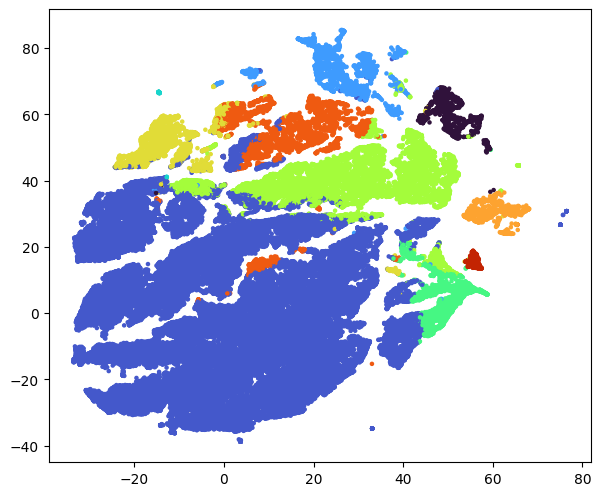

In [54]:
from bokeh.palettes import Turbo256


# setup data
step = len(Turbo256) / num_clusters
kmeans_df = DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['tweets'] = sample_tweets
kmeans_df['color'] = [Turbo256[int(i * step)] for i in kmeans_clusters.tolist()]
kmeans_df = kmeans_df.to_pandas()

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


fig, ax = plt.subplots(figsize=(7, 6), dpi=100)

ax.scatter(kmeans_df['x'], kmeans_df['y'], color=kmeans_df['color'], s = 5)

We can clearly see different groups of clusters, pretty good! Of course it’s not perfect as some clusters seem to be merging with others like deep blue with deep orange, or deep blue with green, but others are completely separated like deep red, black or cyan. This is expected as we could have done a better job of choosing the number of clusters cleverly instead of picking 10 arbitrarily. Added to the fact that this dataset is made of real tweets, which means uncleaned data and outliers, this result seems pretty good. Let’s draw markers for the two earlier tweets from cluster 4 with a black colored X and add a tweet from cluster 6 with a red cross.

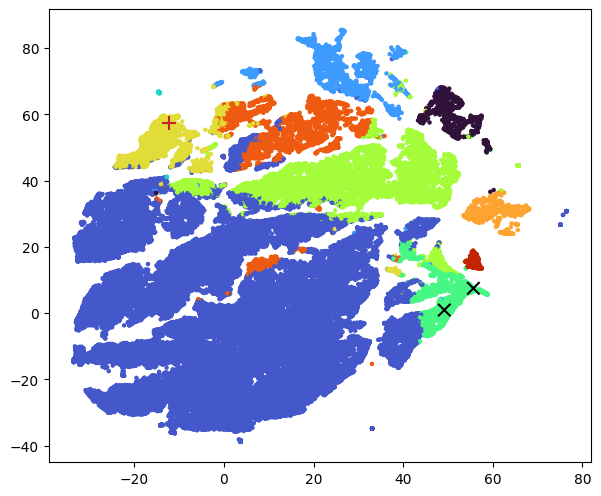

In [55]:
# markers
cluster_4_tweets = [4338, 62623]
cluster_6_tweets = [55737]

def get_glyph_df(tweets_ids, color):
    glyph_df = kmeans_df.iloc[tweets_ids].copy()
    glyph_df['color'] = color
    glyph_df['size'] = 20
    return glyph_df

glyph_4 = get_glyph_df(cluster_4_tweets, '#000000')
glyph_6 = get_glyph_df(cluster_6_tweets, '#c72020')

fig, ax = plt.subplots(figsize=(7, 6), dpi=100)

ax.scatter(kmeans_df['x'], kmeans_df['y'], color=kmeans_df['color'], s = 5)
ax.scatter(glyph_4['x'], glyph_4['y'], color=glyph_4['color'], marker='x', s=80)
ax.scatter(glyph_6['x'], glyph_6['y'], color=glyph_6['color'], marker='+', s=100)

For reference, here are the tweets from cluster 4 (marked with a black X on the graph):

In [56]:
glyph_4[['tweets', 'cluster']]

,tweets,cluster
4338,#StayHome to stay unexposed and not expose others to #COVID19. Only go out for essential services or if you are an essential worker. Stay 6 feet or more away from others. Don't gather in groups. https://t.co/fnXN7UAm4V,4
62623,"While you stay at home to stay safe due the COVID-19 outbreak, ensure you are safe at home.\n\n#staysafe #stayathome #socialdistancing #corona #coronavirus #covid_19 #goodhealth #goodhealthandwellbeing #sdgs #sdg… https://t.co/AFFtusHj6v",4


And here is the tweet from cluster 6 (marked with a red + on the graph):

In [57]:
glyph_6[['tweets', 'cluster']]

,tweets,cluster
55737,"New York, New Jersey, Connecticut residents must refrain from travel for 14 days : CDC\n#COVID19 #CoronaVirusUpdates #CoronaVirusOutbreak #CoronaVirus #COVID_19 #COVID19outbreak #WuhanCoronavirus #COVID19Pandemic #SARSCOV2 #NewYork #NewJersey #UnitedStates \nhttps://t.co/qgDGzKwfP0",6


---
Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.